In [1]:
# Have used plotty so please make sure to install below commands 
#!pip install plotly
#!pip install cufflinks

# Group Case Study : Loan Default Prediction 

# Introduction to the Project

In this case study, we will use EDA to understand how <b>consumer attributes</b> and <b>loan attributes</b> influence the tendency of default. This analysis will help consumer finance company to decide if loan can be given to applicants depending upon their credit history.

When a person applies for a loan, there are two types of decisions that could be taken by the company:

1. **Loan accepted**: If the company approves the loan, there are 3 possible scenarios described below:
   <br>*Fully paid*: Applicant has fully paid the loan (the principal and the interest rate)
   <br>*Current*: Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.
   <br>*Charged-off*: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan 


2. **Loan rejected**: The company had rejected the loan (because the candidate does not meet their requirements etc.). Since the loan was rejected, there is no transactional history of those applicants with the company and so this data is not available with the company (and thus in this dataset)


----

# Exploratory Data Analysis (EDA) into below sections



## **1. Data Sourcing**
>`Loading Data into dataframe`

## **2. Data Cleaning**
>`Null Value Suggestion`<br>
> a. Deleting and Dropping Columns with null percenatge is 100 % <br>
> b. Delete columns where missing values are more than 75% percentage<br><br>
>`Deleting duplicate values`<br><br>
>`Analyize Columns Descriptions`<br>
> a. Remove unnecessary columns <br>
> b. Remove rows where values are 25% empty <br><br>
> `Data Type Check for coloumns`<br>
> a. Convert columns to numeric <br>
> b. Filling appropriate values for NAN <br><br>

## **3. Derived Metics** 
>`Derive Month and Year from Issue Date`<br>
>`Derive Loan amount and Annual Income ratio`<br>


## **4. Univariate Analysis**
>`Contineous Variable`<br>
>`Categorical Variable`<br>

## **5. Bivariate/Multivariate Analysis**
>`Correaltion between contineous Variable`<br>

## **6. Defaulters Probability Analysis**
>`Graphs and Insights`<br>

---------------

## 1. Data Sourcing

### Loading Data into dataframe

In [2]:
import pandas as pd
import numpy as np

import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special 
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set(style="whitegrid")

pd.set_option('display.max_columns', 100)

py.offline.init_notebook_mode(connected=True) # plotting in offilne mode 
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

pd.set_option('display.max_colwidth', -1) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision 

encoding_latin="latin"
loan_df = pd.read_csv("../input/loan.csv",low_memory = False,encoding = encoding_latin)

## 2. Data Cleaning

### Useful methods for plotting

In [3]:
def plot_bar_chat(plotting_frame,x_col_name,y_col_name) :
            
        x_axis_title = x_col_name.title()
        y_axis_title = y_col_name.title()
        
        graph_title = "Bar Chart [" + x_axis_title.title() + " Vs " + y_axis_title.title() + "]"
        
        layout = go.Layout(
             title = graph_title,
             yaxis=dict(
                title=y_axis_title
             ),
             xaxis=dict(
                 title=x_axis_title
             )
        )

        data_to_be_plotted = [
            go.Bar(
                x=plotting_frame[x_col_name], 
                y=plotting_frame[y_col_name]
            )
        ]


        figure = go.Figure(data=data_to_be_plotted,layout=layout)
        py.offline.iplot(figure)
        
        
def plot_pie_chat(plotting_frame,x_col_name,y_col_name) : 
        
        labels = plotting_frame[x_col_name].tolist()
        values = plotting_frame[y_col_name].tolist()

        trace = go.Pie(labels=labels, values=values)

        py.offline.iplot([trace])

        
def plot_box_chart(dataframe) :
    data = []
    for index, column_name in enumerate(dataframe) :
        data.append(
        go.Box(
            y=dataframe.iloc[:, index],
            name=column_name
         ))   
        
    layout = go.Layout(
    yaxis=dict(
        title="Frequency",
        zeroline=False
    ),
       boxmode='group'
    )
    
    fig = go.Figure(data=data, layout=layout)    
    py.offline.iplot(fig) 
    
def plot_group_bar_chart(plot,col,hue) : 
    hue_col = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(plot[col].unique()) + 6 + 5*len(hue_col.unique())
    fig.set_size_inches(width , 10)
    ax = sns.countplot(data = loan_plot, x= col, order=plot[col].value_counts().index,hue = hue,palette="Set2") 
    
    for p in ax.patches:
                # Some segment wise value we are getting as Nan as respective value not present to tackle the Nan using temp_height
                temp_height = p.get_height()
                
                if math.isnan(temp_height):
                    temp_height = 0.01
                    
                
                ax.annotate('{:1.1f}%'.format((temp_height*100)/float(len(loan_plot))), (p.get_x()+0.05, temp_height+20)) 
    
    plt.show()

def validate_year(date) :
    temp = date.split('-')[1]
    lenght = len(temp)
    if lenght == 2 :
        temp = "20"+temp
    else :
        temp = "200"+temp
        
    return temp    

###  Matrix of Datatype , Total Counts and Percentage of Missing Values in Loan Dataframe

In [4]:
# Method to get Meta-Data about any dataframe passed 
def get_meta_data(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes, # data types of columns
                    'Total_Element': dataframe.count(), # total elements in columns
                    'Null_Count': dataframe.isnull().sum(), # total null values in columns
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100 # percentage of null values
                       })
    return metadata_matrix

In [5]:
loan_metadata_matrix = get_meta_data(loan_df)
loan_metadata_matrix.head(2)

Datatype  Total_Element  Null_Count      Null_Percentage
id         int64    39717          0                          0.00
member_id  int64    39717          0                          0.00

### Null Values Analysis

In [6]:
loan_metadata_matrix_group = loan_metadata_matrix.groupby("Null_Percentage").count().reset_index()
loan_metadata_matrix_group.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)

In [7]:
plot_pie_chat(loan_metadata_matrix_group,"Null_Percentage","Null_Count")

<font color='blue'/>**Analysis** - Looking at above chart we can completely remove 54 columns where null values are 100% and potentially looking at others where null values is above some specific threshold

### Deleting and Dropping Columns with null percenatge is 100 %


In [8]:
missing_data_100_precent = loan_metadata_matrix[loan_metadata_matrix["Null_Percentage"] == 100.0]
drop_missing_value_col = missing_data_100_precent.index.tolist()
print("Null Columns before deleting  : " + str(loan_df.shape[1]))
loan_df.drop(drop_missing_value_col,inplace=True,axis=1)
print("Null Columns after deleting : " + str(loan_df.shape[1]))

Null Columns before deleting  : 111
Null Columns after deleting : 57


<font color='blue'/>**Analysis** - Above activity reduced the columns by 50% and will result in better analysis.

### Delete columns where missing values are more than 75% percentage


In [9]:
loan_metadata_matrix = get_meta_data(loan_df)
loan_metadata_matrix_group = loan_metadata_matrix.groupby("Null_Percentage").count().reset_index()
plot_pie_chat(loan_metadata_matrix_group,"Null_Percentage","Null_Count")

In [10]:
missing_data_greater_75_precent = loan_metadata_matrix[(loan_metadata_matrix["Null_Percentage"] > 75.0)]
drop_missing_value_col_75 = missing_data_greater_75_precent.index.tolist()
loan_df.drop(drop_missing_value_col_75,inplace=True,axis=1)

In [11]:
print("Shape after deleting 75% columns ",loan_df.shape ,"rows & columns.")

Shape after deleting 75% columns  (39717, 55) rows & columns.


### Dropping columns where we have single values as they will not add any value to our analysis

In [12]:
unique_value = loan_df.nunique()
col_with_only_one_value = unique_value[unique_value.values == 1]
col_to_drop = col_with_only_one_value.index.tolist()
loan_df.drop(col_to_drop, axis =1, inplace=True)
print("Shape after deleting unique value columns ",loan_df.shape ,"rows & columns.")

Shape after deleting unique value columns  (39717, 46) rows & columns.


### Analyize Columns Descriptions

### a. Remove unnecessary columns

<font color='blue'/>**Analysis** - By looking at the data , below fields doesn't add any value to our case study - 
1. url  -- > URL for the LC page with listing data.
2. desc -- > Loan description provided by the borrower
3. zip_code -- > The first 3 numbers of the zip code provided by the borrower in the loan application.
4. id -- > A unique LC assigned ID for the loan listing.
5. member_id --  This is a unique id and has no use

In [13]:
col_to_drop = ["url","desc","zip_code","id","member_id"]
loan_df.drop(col_to_drop,inplace=True,axis=1)
loan_df.head(5)

loan_amnt  funded_amnt      funded_amnt_inv        term int_rate  \
0  5000       5000                    4,975.00   36 months  10.65%    
1  2500       2500                    2,500.00   60 months  15.27%    
2  2400       2400                    2,400.00   36 months  15.96%    
3  10000      10000                  10,000.00   36 months  13.49%    
4  3000       3000                    3,000.00   60 months  12.69%    

           installment grade sub_grade                 emp_title emp_length  \
0               162.87  B     B2        NaN                       10+ years   
1                59.83  C     C4        Ryder                     < 1 year    
2                84.33  C     C5        NaN                       10+ years   
3               339.31  C     C1        AIR RESOURCES BOARD       10+ years   
4                67.79  B     B5        University Medical Group  1 year      

  home_ownership           annual_inc verification_status issue_d  \
0  RENT                     24,000.00  Verified            Dec-11   
1  RENT                     30,000.00  Source Verified     Dec-11   
2  RENT                     12,252.00  Not Verified        Dec-11   
3  RENT                     49,200.00  Source Verified     Dec-11   
4  RENT                     80,000.00  Source Verified     Dec-11   

   loan_status         purpose                 title addr_state  \
0  Fully Paid   credit_card     Computer              AZ          
1  Charged Off  car             bike                  GA          
2  Fully Paid   small_business  real estate business  IL          
3  Fully Paid   other           personel              CA          
4  Current      other           Personal              OR          

                   dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0                27.65  0            Jan-85           1                
1                 1.00  0            Apr-99           5                
2                 8.72  0            Nov-01           2                
3                20.00  0            Feb-96           1                
4                17.94  0            Jan-96           0                

   mths_since_last_delinq  open_acc  pub_rec  revol_bal revol_util  total_acc  \
0                  nan     3         0        13648      83.70%     9           
1                  nan     3         0        1687       9.40%      4           
2                  nan     2         0        2956       98.50%     10          
3                35.00     10        0        5598       21%        37          
4                38.00     15        0        27783      53.90%     38          

             out_prncp        out_prncp_inv          total_pymnt  \
0                 0.00                 0.00             5,863.16   
1                 0.00                 0.00             1,008.71   
2                 0.00                 0.00             3,005.67   
3                 0.00                 0.00            12,231.89   
4               524.06               524.06             3,513.33   

       total_pymnt_inv      total_rec_prncp        total_rec_int  \
0             5,833.84             5,000.00               863.16   
1             1,008.71               456.46               435.17   
2             3,005.67             2,400.00               605.67   
3            12,231.89            10,000.00             2,214.92   
4             3,513.33             2,475.94             1,037.39   

    total_rec_late_fee           recoveries  collection_recovery_fee  \
0                 0.00                 0.00                 0.00       
1                 0.00               117.08                 1.11       
2                 0.00                 0.00                 0.00       
3                16.97                 0.00                 0.00       
4                 0.00                 0.00                 0.00       

  last_pymnt_d      last_pymnt_amnt last_credit_pull_d  pub_rec_bankruptcies  
0  Jan-15                    171.

### b. Remove rows where values are missing more than 25%

In [14]:
loan_df.shape

(39717, 41)

<font color='blue'/>**Analysis** - Dataset us already cleaned , we dint get any  major missing values
#loan_df.dropna(thresh=45)
#loan_df.shape

### Data Type Check for coloumns

#### a. Convert columns to numeric

In [15]:
loan_data_type = get_meta_data(loan_df)
loan_data_type_float = loan_data_type[loan_data_type["Datatype"] == "float64"]
loan_data_type_int = loan_data_type[loan_data_type["Datatype"] == "int64"]

In [16]:
loan_data_type_float_group = loan_data_type_float.groupby("Null_Percentage").count().reset_index()
plot_pie_chat(loan_data_type_float_group,"Null_Percentage","Null_Count")
loan_data_type_float

Datatype  Total_Element  Null_Count  \
funded_amnt_inv          float64  39717          0            
installment              float64  39717          0            
annual_inc               float64  39717          0            
dti                      float64  39717          0            
mths_since_last_delinq   float64  14035          25682        
out_prncp                float64  39717          0            
out_prncp_inv            float64  39717          0            
total_pymnt              float64  39717          0            
total_pymnt_inv          float64  39717          0            
total_rec_prncp          float64  39717          0            
total_rec_int            float64  39717          0            
total_rec_late_fee       float64  39717          0            
recoveries               float64  39717          0            
collection_recovery_fee  float64  39717          0            
last_pymnt_amnt          float64  39717          0            
pub_rec_bankruptcies     float64  39020          697          

                             Null_Percentage  
funded_amnt_inv                         0.00  
installment                             0.00  
annual_inc                              0.00  
dti                                     0.00  
mths_since_last_delinq                 64.66  
out_prncp                               0.00  
out_prncp_inv                           0.00  
total_pymnt                             0.00  
total_pymnt_inv                         0.00  
total_rec_prncp                         0.00  
total_rec_int                           0.00  
total_rec_late_fee                      0.00  
recoveries                              0.00  
collection_recovery_fee                 0.00  
last_pymnt_amnt                         0.00  
pub_rec_bankruptcies                    1.75

<font color='blue'/>**Analysis** - 87% of float datatypes have correct values and can be converted into numeric for analyis 

In [17]:
columns_to_convert_numeric = loan_data_type_float[loan_data_type_float["Null_Count"] == 0].index.tolist()

In [18]:
loan_data_type_int_group = loan_data_type_int.groupby("Null_Percentage").count().reset_index()
plot_pie_chat(loan_data_type_int_group,"Null_Percentage","Null_Count")
loan_data_type_int

Datatype  Total_Element  Null_Count      Null_Percentage
loan_amnt       int64    39717          0                          0.00
funded_amnt     int64    39717          0                          0.00
delinq_2yrs     int64    39717          0                          0.00
inq_last_6mths  int64    39717          0                          0.00
open_acc        int64    39717          0                          0.00
pub_rec         int64    39717          0                          0.00
revol_bal       int64    39717          0                          0.00
total_acc       int64    39717          0                          0.00

<font color='blue'/>**Analysis** -No need to fill any NaN value are there are none in dataset. But all the **amount** fields needs to be converted to numeric for calculation. 

In [19]:
# adding more columns which needs to be converted to float
columns_to_convert_numeric.extend(["loan_amnt","funded_amnt"])
columns_to_convert_numeric

['funded_amnt_inv',
 'installment',
 'annual_inc',
 'dti',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'loan_amnt',
 'funded_amnt']

### Converting columns into float datatype

In [20]:
loan_df[columns_to_convert_numeric] = loan_df[columns_to_convert_numeric].astype(float)

# Converting Interest Rate Column into Floating , which will be used during 
#further analysis , converting str field to float 
loan_df["int_rate"] = loan_df["int_rate"].apply(lambda x: x.rstrip("%")).astype(float)


loan_df.head(2)

loan_amnt          funded_amnt      funded_amnt_inv        term  \
0             5,000.00             5,000.00             4,975.00   36 months   
1             2,500.00             2,500.00             2,500.00   60 months   

              int_rate          installment grade sub_grade emp_title  \
0                10.65               162.87  B     B2        NaN        
1                15.27                59.83  C     C4        Ryder      

  emp_length home_ownership           annual_inc verification_status issue_d  \
0  10+ years  RENT                     24,000.00  Verified            Dec-11   
1  < 1 year   RENT                     30,000.00  Source Verified     Dec-11   

   loan_status      purpose     title addr_state                  dti  \
0  Fully Paid   credit_card  Computer  AZ                       27.65   
1  Charged Off  car          bike      GA                        1.00   

   delinq_2yrs earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
0  0            Jan-85           1                               nan      
1  0            Apr-99           5                               nan      

   open_acc  pub_rec  revol_bal revol_util  total_acc            out_prncp  \
0  3         0        13648      83.70%     9                         0.00   
1  3         0        1687       9.40%      4                         0.00   

         out_prncp_inv          total_pymnt      total_pymnt_inv  \
0                 0.00             5,863.16             5,833.84   
1                 0.00             1,008.71             1,008.71   

       total_rec_prncp        total_rec_int   total_rec_late_fee  \
0             5,000.00               863.16                 0.00   
1               456.46               435.17                 0.00   

            recoveries  collection_recovery_fee last_pymnt_d  \
0                 0.00                 0.00      Jan-15        
1               117.08                 1.11      Apr-13        

       last_pymnt_amnt last_credit_pull_d  pub_rec_bankruptcies  
0               171.62  May-16                            0.00   
1               119.66  Sep-13                            0.00

### b. Filling appropriate values for NAN

In [21]:
columns_need_cleaning = get_meta_data(loan_df)
columns_need_cleaning = columns_need_cleaning[columns_need_cleaning["Null_Count"] > 0]
columns_need_cleaning.head(20)

Datatype  Total_Element  Null_Count  \
emp_title               object   37258          2459         
emp_length              object   38642          1075         
title                   object   39706          11           
mths_since_last_delinq  float64  14035          25682        
revol_util              object   39667          50           
last_pymnt_d            object   39646          71           
last_credit_pull_d      object   39715          2            
pub_rec_bankruptcies    float64  39020          697          

                            Null_Percentage  
emp_title                              6.19  
emp_length                             2.71  
title                                  0.03  
mths_since_last_delinq                64.66  
revol_util                             0.13  
last_pymnt_d                           0.18  
last_credit_pull_d                     0.01  
pub_rec_bankruptcies                   1.75

<font color='blue'/>**Analysis** -By looking at above we need to handle **emp_length** as this will be out main feature for analysis and we can delete **mths_since_last_delinq** as it has a lot of values missing compare to other features.

In [22]:
# not required at the moment for analysis and has 64% null values which cannot be substitued 
to_drop = ["mths_since_last_delinq","emp_title"]
loan_df.drop(to_drop , inplace=True,axis=1)

In [23]:
loan_df_temp = loan_df.filter(columns_need_cleaning.index.tolist())
loan_df_temp.head()

emp_length                 title revol_util last_pymnt_d last_credit_pull_d  \
0  10+ years  Computer              83.70%     Jan-15       May-16              
1  < 1 year   bike                  9.40%      Apr-13       Sep-13              
2  10+ years  real estate business  98.50%     Jun-14       May-16              
3  10+ years  personel              21%        Jan-15       Apr-16              
4  1 year     Personal              53.90%     May-16       May-16              

   pub_rec_bankruptcies  
0                 0.00   
1                 0.00   
2                 0.00   
3                 0.00   
4                 0.00

<font color='blue'/>**Analysis** - If employment lenght is not given it means that either it is absent or person owns a business etc.Hence replacing value with self employed or business or unknown , we all aggreed upon Self-Employed value

In [24]:
print(loan_df["emp_length"].unique())
loan_df["emp_length"].fillna('Self-Employed',inplace=True)
print(loan_df.emp_length.unique())

['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' 'Self-Employed']


In [25]:
# Adding frequnecy columns so as to use it while plotting graphs
loan_df["frequency"] = loan_df["loan_amnt"] - loan_df["loan_amnt"]
len(loan_df["frequency"].astype(int))

39717

## 3. Derived Metrics

### Derive Month and Year from Issue Date

In [26]:
loan_df['issue_month']  = loan_df['issue_d'].apply(lambda date:date.split('-')[0])
loan_df['issue_year'] = loan_df['issue_d'].apply(validate_year)
loan_df[['issue_d','issue_month','issue_year']].head()

issue_d issue_month issue_year
0  Dec-11  Dec         2011     
1  Dec-11  Dec         2011     
2  Dec-11  Dec         2011     
3  Dec-11  Dec         2011     
4  Dec-11  Dec         2011

### Derive Loan amount and Annual Income ratio

In [27]:
loan_df['loan_amt_inc_ratio']=loan_df['loan_amnt']/loan_df['annual_inc']
loan_df[['loan_amt_inc_ratio','loan_amnt','annual_inc']].head()

loan_amt_inc_ratio            loan_amnt           annual_inc
0                 0.21             5,000.00            24,000.00
1                 0.08             2,500.00            30,000.00
2                 0.20             2,400.00            12,252.00
3                 0.20            10,000.00            49,200.00
4                 0.04             3,000.00            80,000.00

In [28]:
loan_df["loan_amnt"].describe()

count              39,717.00
mean               11,219.44
std                 7,456.67
min                   500.00
25%                 5,500.00
50%                10,000.00
75%                15,000.00
max                35,000.00
Name: loan_amnt, dtype: float64

## 4.Univariate Analysis

### Contineous Variable

### 1. Loan Amount

In [29]:
plot_box_chart(pd.DataFrame(loan_df["loan_amnt"])) # hover cursor above graph

<font color='blue'/>**Analysis** - Most of the loan amount is distributed between **Rs. 5500 to Rs. 15000**

### 2. Interest Rate

In [30]:
plot_box_chart(pd.DataFrame(loan_df["int_rate"])) # hover cursor above graph

<font color='blue'/>**Analysis** - Most of the interest is distributed between **9.25** to **14.59**

### 3. Annual Income


In [31]:
plot_box_chart(pd.DataFrame(loan_df["annual_inc"])) # hover cursor above graph

<font color='blue'/>**Analysis** - This graph is higly skewed and must have an outlier which is pulling down entire plotting . Lets check distribution using describe command.

In [32]:
loan_df["annual_inc"].describe()

count              39,717.00
mean               68,968.93
std                63,793.77
min                 4,000.00
25%                40,404.00
50%                59,000.00
75%                82,300.00
max             6,000,000.00
Name: annual_inc, dtype: float64

<font color='blue'/>**Analysis** - Now if we look at the mean and max value there is huge diffrence and needs to be corrected. Clearly max value is an outlier which needs to be corrected otherwise we will have huge deviation in our analysis.

In [33]:
outlier_value = loan_df["annual_inc"].quantile(0.995)
loan_df = loan_df[loan_df["annual_inc"] < outlier_value]
loan_df["annual_inc"].describe()

count              39,494.00
mean               66,378.26
std                37,413.21
min                 4,000.00
25%                40,000.00
50%                58,776.00
75%                81,996.00
max               294,000.00
Name: annual_inc, dtype: float64

In [34]:
plot_box_chart(pd.DataFrame(loan_df["annual_inc"]))  # hover cursor above graph

<font color='blue'/>**Analysis** - Most of the annual income is distributed between **40k to 82k**

### Categorical Variables

In [35]:
loan_df.head()

loan_amnt          funded_amnt      funded_amnt_inv        term  \
0             5,000.00             5,000.00             4,975.00   36 months   
1             2,500.00             2,500.00             2,500.00   60 months   
2             2,400.00             2,400.00             2,400.00   36 months   
3            10,000.00            10,000.00            10,000.00   36 months   
4             3,000.00             3,000.00             3,000.00   60 months   

              int_rate          installment grade sub_grade emp_length  \
0                10.65               162.87  B     B2        10+ years   
1                15.27                59.83  C     C4        < 1 year    
2                15.96                84.33  C     C5        10+ years   
3                13.49               339.31  C     C1        10+ years   
4                12.69                67.79  B     B5        1 year      

  home_ownership           annual_inc verification_status issue_d  \
0  RENT                     24,000.00  Verified            Dec-11   
1  RENT                     30,000.00  Source Verified     Dec-11   
2  RENT                     12,252.00  Not Verified        Dec-11   
3  RENT                     49,200.00  Source Verified     Dec-11   
4  RENT                     80,000.00  Source Verified     Dec-11   

   loan_status         purpose                 title addr_state  \
0  Fully Paid   credit_card     Computer              AZ          
1  Charged Off  car             bike                  GA          
2  Fully Paid   small_business  real estate business  IL          
3  Fully Paid   other           personel              CA          
4  Current      other           Personal              OR          

                   dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0                27.65  0            Jan-85           1                
1                 1.00  0            Apr-99           5                
2                 8.72  0            Nov-01           2                
3                20.00  0            Feb-96           1                
4                17.94  0            Jan-96           0                

   open_acc  pub_rec  revol_bal revol_util  total_acc            out_prncp  \
0  3         0        13648      83.70%     9                         0.00   
1  3         0        1687       9.40%      4                         0.00   
2  2         0        2956       98.50%     10                        0.00   
3  10        0        5598       21%        37                        0.00   
4  15        0        27783      53.90%     38                      524.06   

         out_prncp_inv          total_pymnt      total_pymnt_inv  \
0                 0.00             5,863.16             5,833.84   
1                 0.00             1,008.71             1,008.71   
2                 0.00             3,005.67             3,005.67   
3                 0.00            12,231.89            12,231.89   
4               524.06             3,513.33             3,513.33   

       total_rec_prncp        total_rec_int   total_rec_late_fee  \
0             5,000.00               863.16                 0.00   
1               456.46               435.17                 0.00   
2             2,400.00               605.67                 0.00   
3            10,000.00             2,214.92                16.97   
4             2,475.94             1,037.39                 0.00   

            recoveries  collection_recovery_fee last_pymnt_d  \
0                 0.00                 0.00      Jan-15        
1               117.08                 1.11      Apr-13        
2                 0.00                 0.00      Jun-14        
3                 0.00                 0.00      Jan-15        
4                 0.00                 0.00      May-16        

       last_pymnt_amnt last_credit_pull_d  pub_rec_bankruptcies  \
0               171.62  May-16                            0.00    
1               119.66  Sep-13

**Plotting graphs for below columns to gets insights-** 
1. emp_length	
2. home_ownership
3. verification_status
4. loan_status
5. purpose
6. issue_year

### Plotting for Employee Length

In [36]:
plot = loan_df.groupby("emp_length").frequency.count().reset_index()
plot_bar_chat(plot,"emp_length","frequency")

<font color='blue'/>**Analysis** - Applicants have more than 10+ years have taken maximum number of loans.

### Plotting for home ownership

In [37]:
plot_home_ownership = loan_df.groupby("home_ownership").frequency.count().reset_index()
plot_bar_chat(plot_home_ownership,"home_ownership","frequency")

<font color='blue'/>**Analysis** - Now if we look at the graph above categoty "NONE" and "OTHER" are very small and can be ignored as part of our analysis.

In [38]:
loan_df = loan_df[loan_df["home_ownership"].isin(["OWN","RENT","MORTGAGE"]) ]
plot_home_ownership_1 = loan_df.groupby("home_ownership").frequency.count().reset_index()
plot_bar_chat(plot_home_ownership_1,"home_ownership","frequency")

<font color='blue'/>**Analysis** - Mortagage and Rent applicants have taken more number of loans

### Plotting for verification_status

In [39]:
plot_verification_status = loan_df.groupby("verification_status").frequency.count().reset_index()
plot_bar_chat(plot_verification_status,"verification_status","frequency")

<font color='blue'/>**Analysis** - Now there can only be two cases Verified or not verified , so esentially Source Verified and Verified represent same thing and it needs to be merged to get good view.

In [40]:
loan_df["verification_status"] = loan_df["verification_status"].replace("Source Verified","Verified")
plot_verification_status = loan_df.groupby("verification_status").frequency.count().reset_index()
plot_bar_chat(plot_verification_status,"verification_status","frequency")

<font color='blue'/>**Analysis** - Not verified loan percenatge is significant which can result in charge-off loans, bank should work towards lowering this number of not verified loan

### Plotting for loan_status

In [41]:
plot_loan_status = loan_df.groupby("loan_status").frequency.count().reset_index()
plot_pie_chat(plot_loan_status,"loan_status","frequency")

<font color='blue'/>**Analysis** - Looking at above distirbution company is in pretty good shape as applicants are finishing off the loan ammount in timely basis as it is whooping 83% but still needs to see the distribution across diffrent categories and against loan amount taken. We still see charge off percentage as 14.2% from total distribution

### Plotting for purpose of loan

In [42]:
plot_purpose = loan_df.groupby("purpose").frequency.count().reset_index()
plot_bar_chat(plot_purpose,"purpose","frequency")

<font color='blue'/>**Analysis** - Applicants have taken loan for debt consolidation is significantly high

### Plotting for issue year

In [43]:
plot_issue_year = loan_df.groupby("issue_year").frequency.count().reset_index()
plot_bar_chat(plot_issue_year,"issue_year","frequency")

<font color='blue'/>**Analysis** - Steady increase in loan applicats and applicants have taken for maximum number of loans in 2011.Loan applicants are increasing year on year, approx **50% of loan applicants received loans in 2011**.

### Now showing distribution across categories 

### How the distibution looks like for purpose of taking loan

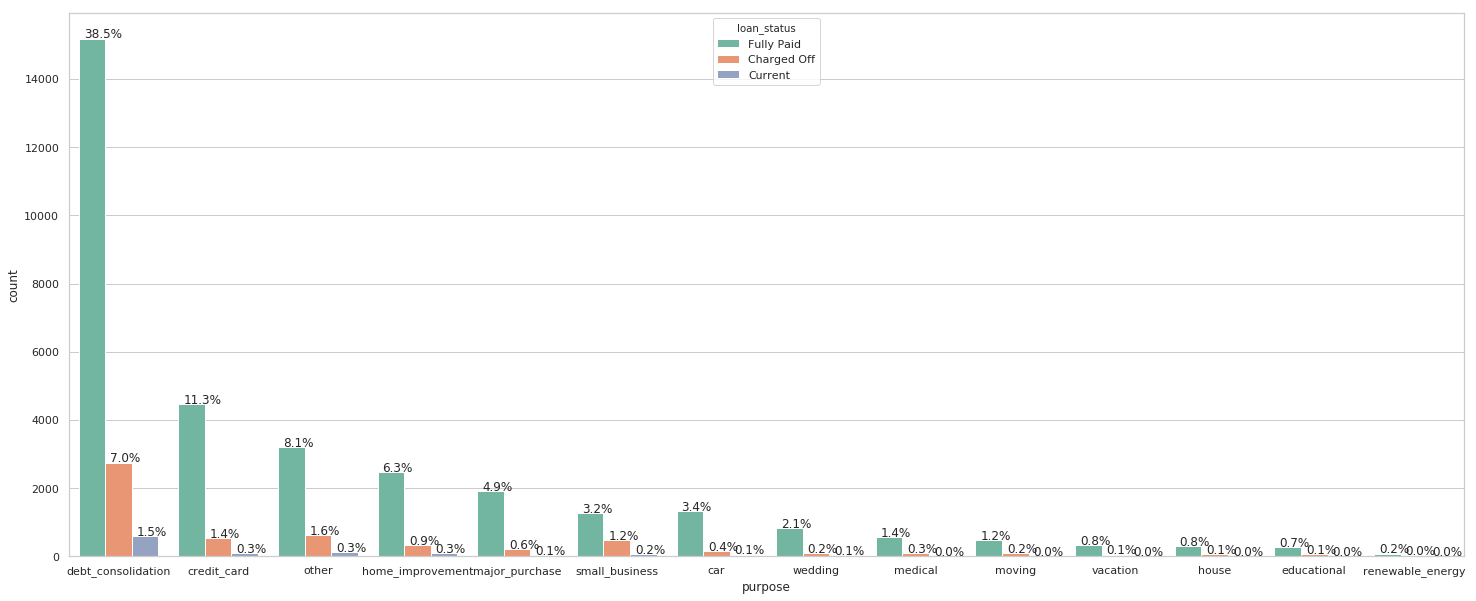

In [44]:
loan_plot = loan_df[["purpose","loan_status"]]
plot_group_bar_chart(loan_plot,"purpose","loan_status")

<font color='blue'/>**Analysis** - Approx **47%** of the applicants applied loan for paying their **other loans(Debt Consolidation)**

### How the distibution looks for the applicants home ownership vs loan status 

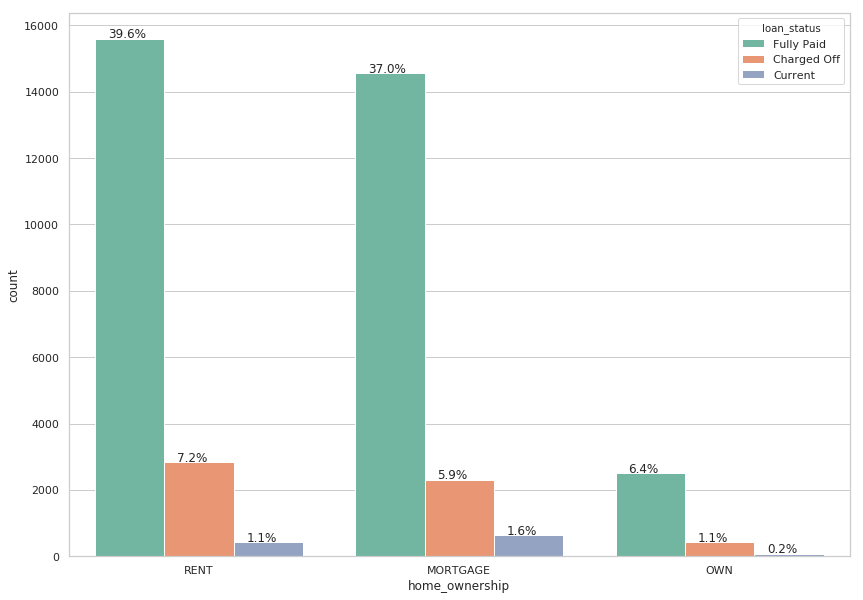

In [45]:
loan_plot = loan_df[["home_ownership","loan_status"]]
plot_group_bar_chart(loan_plot,"home_ownership","loan_status")

<font color='blue'/>**Analysis** - **48%** of applicants are living in **Rented home** whereas **46%** applicants were **Mortagaged** their home

### How the distibution looks like for loan term Vs loan status 

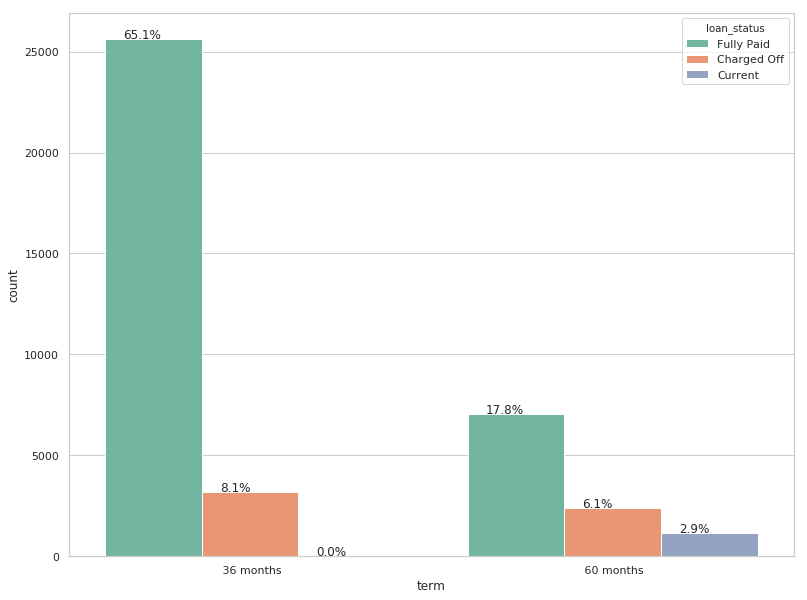

In [46]:
loan_plot = loan_df[["term","loan_status"]]
plot_group_bar_chart(loan_plot,"term","loan_status")

<font color='blue'/>**Analysis** - Approx **73%** of applicants applied loan for **36 months** term period, but there is no active loan for 36 month period

## Bivariate/Multivariate Analysis

### Finding correlatoin between amount fields 

In [47]:
loan_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies', 'frequency', 'issue_month', 'issue_year',
       'loan_amt_inc_ratio'],
      dtype='object')

In [48]:
# picking relevent (contineous variable) fields to check if they are corelated , 
col_for_corr = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv','int_rate',
                'installment','annual_inc', 'dti', 'out_prncp', 'out_prncp_inv',
                'loan_amt_inc_ratio']
loan_corr = loan_df.filter(col_for_corr)

In [49]:
corr = loan_corr.corr(method ='pearson')
corr

loan_amnt          funded_amnt  \
loan_amnt                          1.00                 0.98   
funded_amnt                        0.98                 1.00   
funded_amnt_inv                    0.94                 0.96   
int_rate                           0.31                 0.31   
installment                        0.93                 0.96   
annual_inc                         0.42                 0.41   
dti                                0.07                 0.07   
out_prncp                          0.19                 0.20   
out_prncp_inv                      0.19                 0.20   
loan_amt_inc_ratio                 0.62                 0.61   

                        funded_amnt_inv             int_rate  \
loan_amnt                          0.94                 0.31   
funded_amnt                        0.96                 0.31   
funded_amnt_inv                    1.00                 0.31   
int_rate                           0.31                 1.00   
installment                        0.91                 0.28   
annual_inc                         0.40                 0.08   
dti                                0.08                 0.11   
out_prncp                          0.21                 0.13   
out_prncp_inv                      0.21                 0.14   
loan_amt_inc_ratio                 0.58                 0.22   

                            installment           annual_inc  \
loan_amnt                          0.93                 0.42   
funded_amnt                        0.96                 0.41   
funded_amnt_inv                    0.91                 0.40   
int_rate                           0.28                 0.08   
installment                        1.00                 0.42   
annual_inc                         0.42                 1.00   
dti                                0.06                -0.12   
out_prncp                          0.13                 0.06   
out_prncp_inv                      0.13                 0.06   
loan_amt_inc_ratio                 0.56                -0.31   

                                    dti            out_prncp  \
loan_amnt                          0.07                 0.19   
funded_amnt                        0.07                 0.20   
funded_amnt_inv                    0.08                 0.21   
int_rate                           0.11                 0.13   
installment                        0.06                 0.13   
annual_inc                        -0.12                 0.06   
dti                                1.00                 0.04   
out_prncp                          0.04                 1.00   
out_prncp_inv                      0.04                 1.00   
loan_amt_inc_ratio                 0.14                 0.13   

                          out_prncp_inv   loan_amt_inc_ratio  
loan_amnt                          0.19                 0.62  
funded_amnt                        0.20                 0.61  
funded_amnt_inv                    0.21                 0.58  
int_rate                           0.14                 0.22  
installment                        0.13                 0.56  
annual_inc                         0.06                -0.31  
dti                                0.04                 0.14  
out_prncp                          1.00                 0.13  
out_prncp_inv                      1.00                 0.13  
loan_amt_inc_ratio                 0.13                 1.00

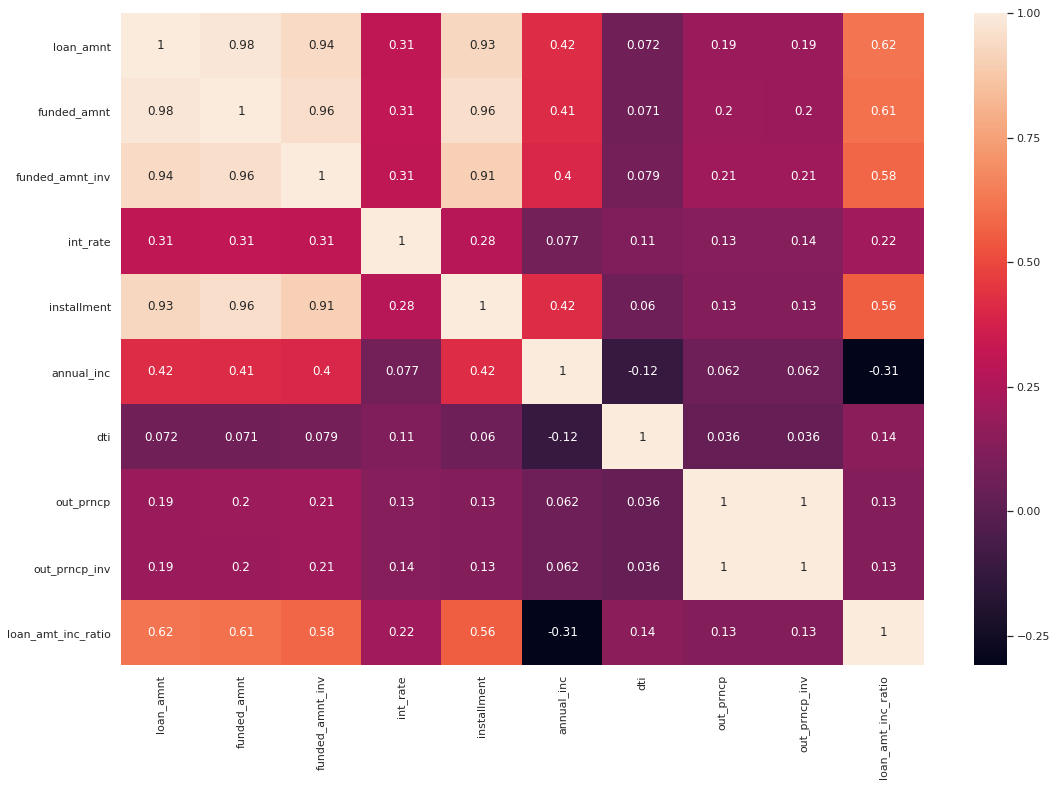

In [50]:
plt.subplots(figsize=(18, 12))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot= True)
plt.show()

<font color='blue'/>**Analysis** - It is clear from the Heatmap that how **'loan_amnt','funded_amnt' & 'funded_amnt_inv' are closely interrelated**.

 So we can take any one column out of them for our analysis

### What is the purpose of loan and the amount corresponding to each loan status

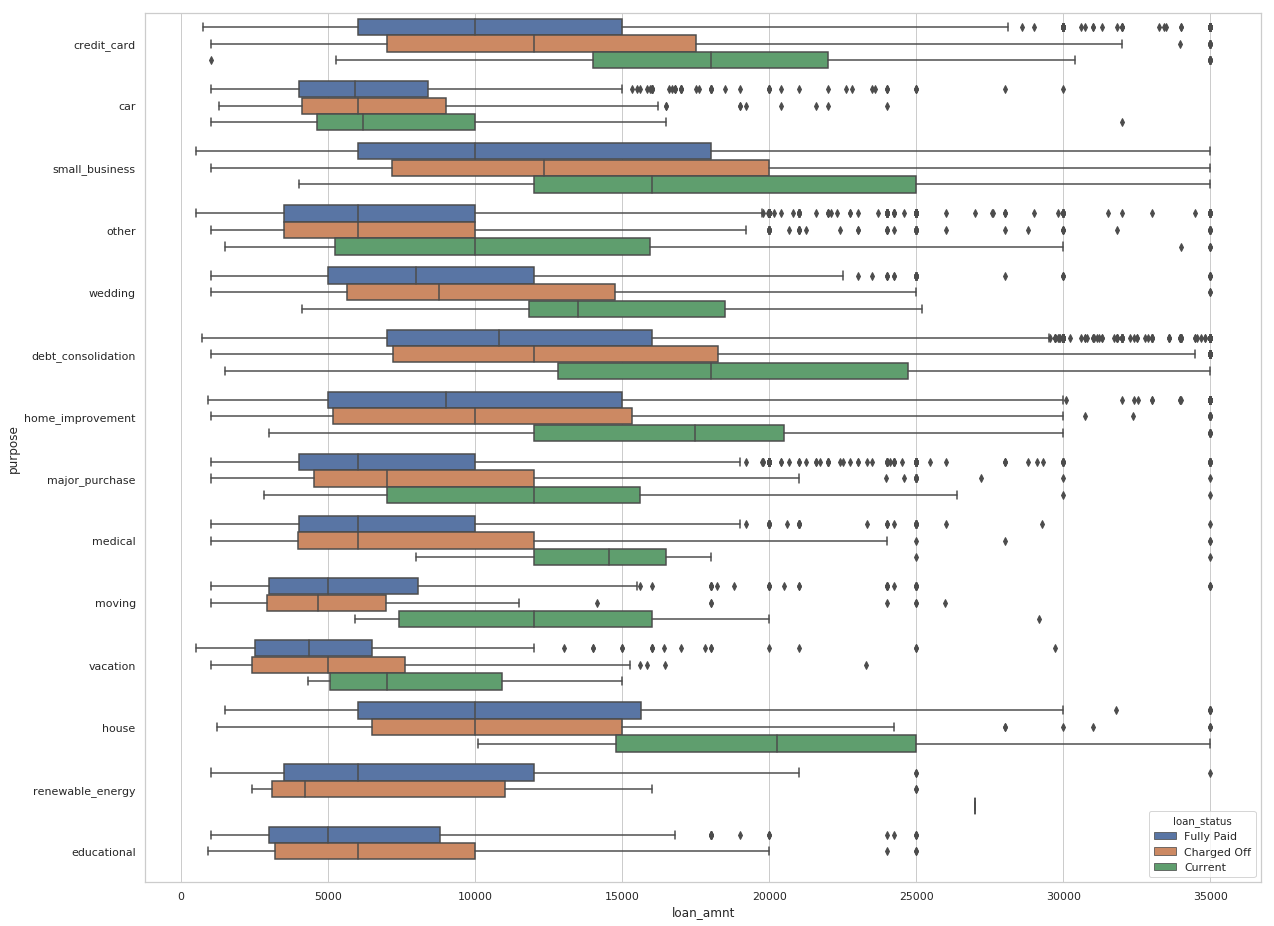

In [51]:
plt.figure(figsize=(20,16))
sns.boxplot(data =loan_df, x='loan_amnt', y='purpose', hue ='loan_status')

plt.show()

<font color='blue'/>**Analysis** - By looking at above plot we can see **other and major purchase** category have a lot of outlieres in charge off and which will contribute to more losses for the bank. **Small business** also needs to be looked at closely and  hence while giving loan for above three categories bank should have more proactive checks.

### Lets see how defaulting related to year of service 

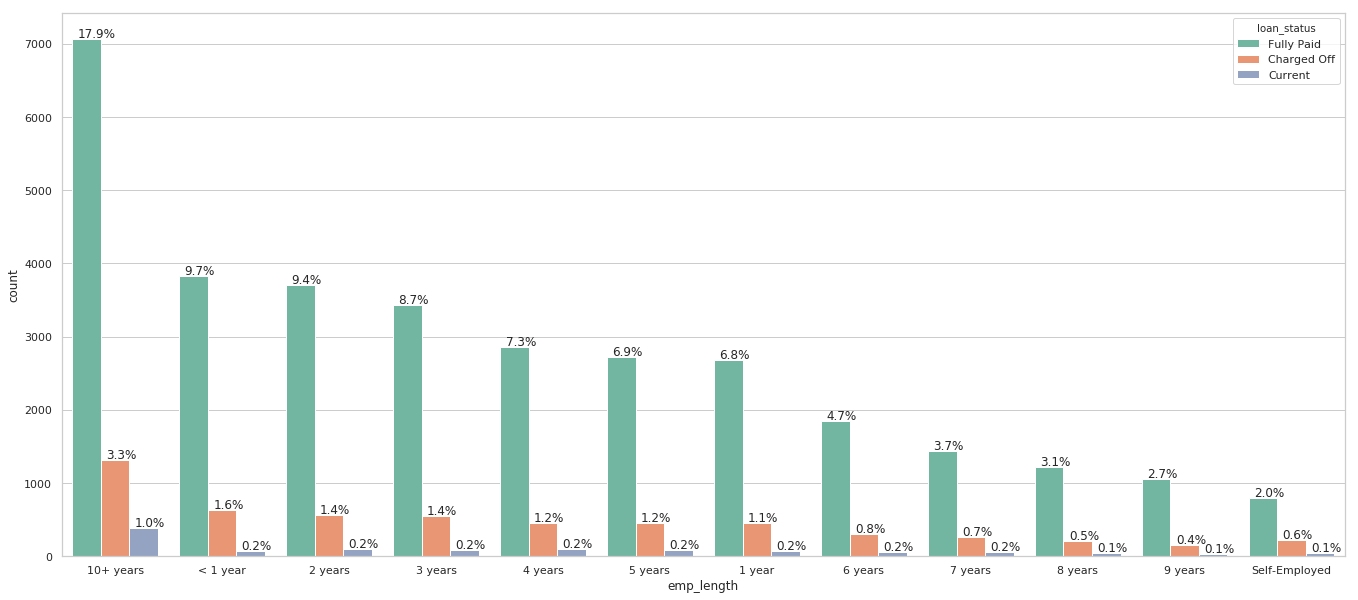

In [52]:
loan_plot = loan_df[["emp_length","loan_status"]]
plot_group_bar_chart(loan_plot,"emp_length","loan_status")

<font color='blue'/>**Analysis** - Loan taken in maximum number by 10+ years. Approx **23%** Loan has been taken

### Lets see how loan purpose is related to year of service 

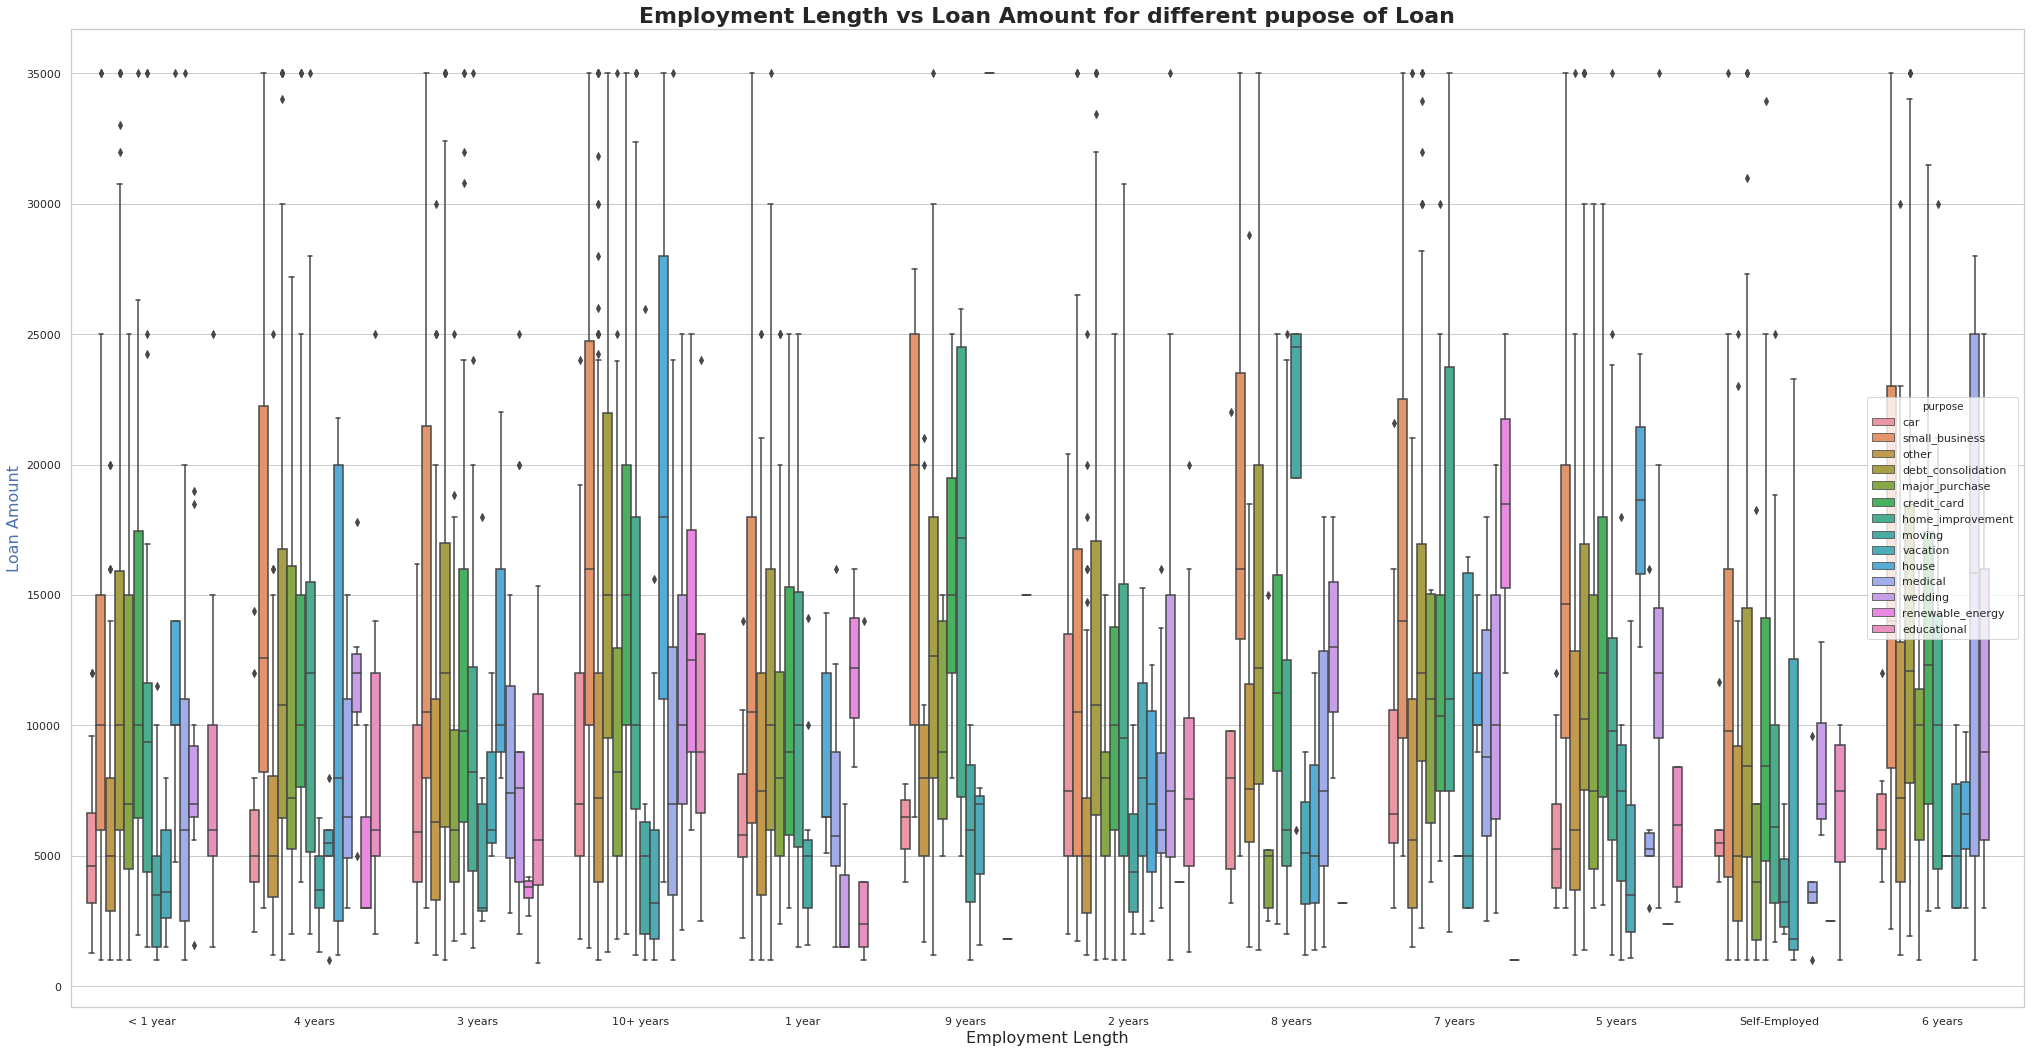

In [53]:

# Employment Length vs Loan Amount for different pupose of Loan

loanstatus=loan_df.pivot_table(index=['loan_status','purpose','emp_length'],values='loan_amnt',aggfunc=('count')).reset_index()
loanstatus=loan_df.loc[loan_df['loan_status']=='Charged Off']

ax = plt.figure(figsize=(35, 18))
ax = sns.boxplot(x='emp_length',y='loan_amnt',hue='purpose',data=loanstatus)
ax.set_title('Employment Length vs Loan Amount for different pupose of Loan',fontsize=22,weight="bold")
ax.set_xlabel('Employment Length',fontsize=16)
ax.set_ylabel('Loan Amount',color = 'b',fontsize=16)
plt.show()

<font color='blue'/>**Analysis** - Above graph reveles a lot of information - 
10+ year Applicants have taken maximum number of loan taken for below categories across other experinces - 
1. credit card
2. car
3. small business
4. other


In [54]:
loan_df.head()

loan_amnt          funded_amnt      funded_amnt_inv        term  \
0             5,000.00             5,000.00             4,975.00   36 months   
1             2,500.00             2,500.00             2,500.00   60 months   
2             2,400.00             2,400.00             2,400.00   36 months   
3            10,000.00            10,000.00            10,000.00   36 months   
4             3,000.00             3,000.00             3,000.00   60 months   

              int_rate          installment grade sub_grade emp_length  \
0                10.65               162.87  B     B2        10+ years   
1                15.27                59.83  C     C4        < 1 year    
2                15.96                84.33  C     C5        10+ years   
3                13.49               339.31  C     C1        10+ years   
4                12.69                67.79  B     B5        1 year      

  home_ownership           annual_inc verification_status issue_d  \
0  RENT                     24,000.00  Verified            Dec-11   
1  RENT                     30,000.00  Verified            Dec-11   
2  RENT                     12,252.00  Not Verified        Dec-11   
3  RENT                     49,200.00  Verified            Dec-11   
4  RENT                     80,000.00  Verified            Dec-11   

   loan_status         purpose                 title addr_state  \
0  Fully Paid   credit_card     Computer              AZ          
1  Charged Off  car             bike                  GA          
2  Fully Paid   small_business  real estate business  IL          
3  Fully Paid   other           personel              CA          
4  Current      other           Personal              OR          

                   dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0                27.65  0            Jan-85           1                
1                 1.00  0            Apr-99           5                
2                 8.72  0            Nov-01           2                
3                20.00  0            Feb-96           1                
4                17.94  0            Jan-96           0                

   open_acc  pub_rec  revol_bal revol_util  total_acc            out_prncp  \
0  3         0        13648      83.70%     9                         0.00   
1  3         0        1687       9.40%      4                         0.00   
2  2         0        2956       98.50%     10                        0.00   
3  10        0        5598       21%        37                        0.00   
4  15        0        27783      53.90%     38                      524.06   

         out_prncp_inv          total_pymnt      total_pymnt_inv  \
0                 0.00             5,863.16             5,833.84   
1                 0.00             1,008.71             1,008.71   
2                 0.00             3,005.67             3,005.67   
3                 0.00            12,231.89            12,231.89   
4               524.06             3,513.33             3,513.33   

       total_rec_prncp        total_rec_int   total_rec_late_fee  \
0             5,000.00               863.16                 0.00   
1               456.46               435.17                 0.00   
2             2,400.00               605.67                 0.00   
3            10,000.00             2,214.92                16.97   
4             2,475.94             1,037.39                 0.00   

            recoveries  collection_recovery_fee last_pymnt_d  \
0                 0.00                 0.00      Jan-15        
1               117.08                 1.11      Apr-13        
2                 0.00                 0.00      Jun-14        
3                 0.00                 0.00      Jan-15        
4                 0.00                 0.00      May-16        

       last_pymnt_amnt last_credit_pull_d  pub_rec_bankruptcies  \
0               171.62  May-16                            0.00    
1               119.66  Sep-13

## Analysis driving factors (or driver variables) behind loan default

**Aim-**
1. Identify ‘risky’ applicants to minimize the losses.
2. The customers labelled as 'charged-off' are the 'defaulters'.

**Objective-**
1. To identify varibale responsible for triggering charged-off or defaulters.

**Defination for Charge-off -**  
</br>The term “charge-off” means the business that gave you the loan, typically a card company or retailer, has written off the amount owed as uncollectable, closed your account, and declared it a loss.

No clear formula to predict charge-off and we need check charge-off trend against diffrent parameters.  

Now lets assume below parameter might trigger for charge-off - 
1. employment length (categorical variable)
2. grades (categorical variable)
3. purpose (categorical variable)
4. location (categorical variable)
5. loan_amnt   (should be converted to bands i.e. categorical variable)
6. int_rate    (should be converted to bands i.e. categorical variable)
7. annual_inc  (should be converted to bands i.e. categorical variable)


Charge-off is defined as number but to get insights we need to covert this in some kind of ratio so to compare the display the trend against above metioned field. </br>

Lets keep it super simple and calculate the probability of default - </br></br>

    Probability of Default Loan = (Occurance of Default Loan) / (Total Loan disbursed)
    

### Function to calculate defaulter percentages

In [55]:
def calculate_defaulter_precentage(dataframe,column) :
    def_tab = pd.crosstab(dataframe[column], dataframe['loan_status'],margins=True)
    def_tab['All'] = def_tab['Charged Off'] + def_tab['Current'] + def_tab['Fully Paid']
    def_tab['Loan Default Probability'] = round((def_tab['Charged Off']/def_tab['All']),3)
    def_tab = def_tab[0:-1] # removing last row with sum totol 
    return def_tab

### Function to plot graph between bivariate and derived variables 

In [56]:
def plot_bar_line_chart(dataframe,column,stacked=False):
    
    plot = calculate_defaulter_precentage(dataframe,column)
    
    display(plot)
    
    #initializing line plot
    linePlot = plot[['Loan Default Probability']] 
    line = linePlot.plot(figsize=(20,8), marker='o',color = 'r',lw=2)
    line.set_title(dataframe[column].name.title()+' vs Loan Default Probability',fontsize=20,weight="bold")
    line.set_xlabel(dataframe[column].name.title(),fontsize=14)
    line.set_ylabel('Loan Default Probability',color = 'r',fontsize=20)
    
    #initializing bar plot
    barPlot =  plot.iloc[:,0:3] 
    bar = barPlot.plot(kind='bar',ax = line,rot=1,secondary_y=True,stacked=stacked)
    bar.set_ylabel('Number of Applicants',color = 'r',fontsize=20)
    
    plt.show()

### Plotting employment length probablility with defaulting behaviour  

loan_status    Charged Off  Current  Fully Paid   All  \
emp_length                                              
1 year         451          71       2685        3207   
10+ years      1317         389      7071        8777   
2 years        563          97       3700        4360   
3 years        550          83       3430        4063   
4 years        458          94       2865        3417   
5 years        456          87       2716        3259   
6 years        305          61       1851        2217   
7 years        261          62       1440        1763   
8 years        203          43       1218        1464   
9 years        158          32       1061        1251   
< 1 year       636          74       3834        4544   
Self-Employed  227          42       803         1072   

loan_status    Loan Default Probability  
emp_length                               
1 year                        0.14       
10+ years                     0.15       
2 years                       0.13       
3 years                       0.14       
4 years                       0.13       
5 years                       0.14       
6 years                       0.14       
7 years                       0.15       
8 years                       0.14       
9 years                       0.13       
< 1 year                      0.14       
Self-Employed                 0.21

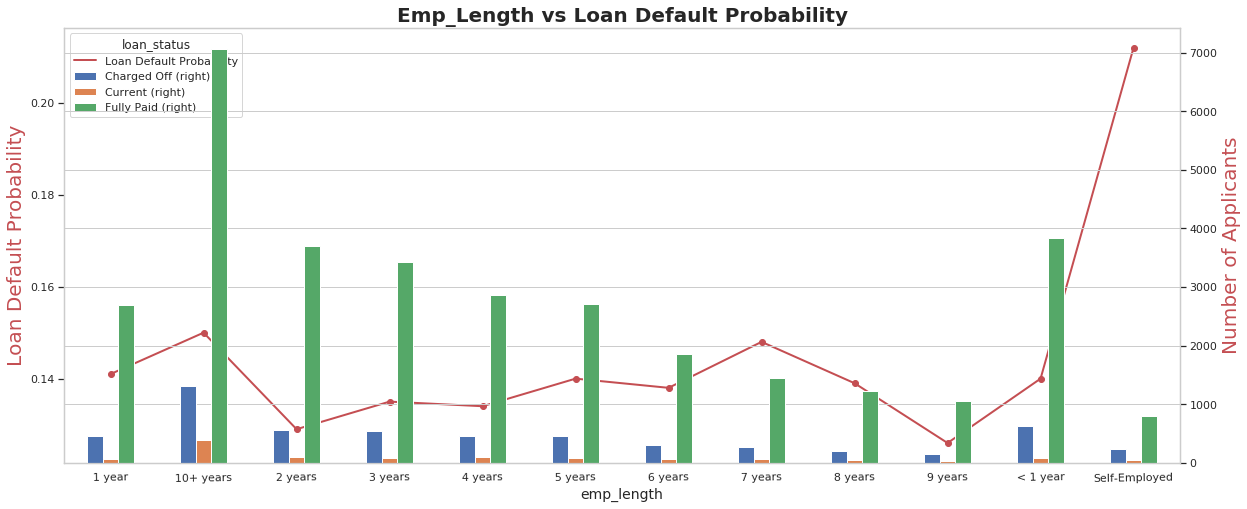

In [57]:
plot_bar_line_chart(loan_df,"emp_length")

<font color='blue'/>**Analysis** - Applicants who are **Self-Employed and less than 1 year** of experience are more probable of Likely to be Defaulter

### Plotting grades and sub-grades probablility with defaulting behaviour  

loan_status  Charged Off  Current  Fully Paid    All  Loan Default Probability
grade                                                                         
A            600          40       9386        10026                 0.06     
B            1412         345      10176       11933                 0.12     
C            1340         262      6429        8031                  0.17     
D            1111         220      3929        5260                  0.21     
E            708          178      1915        2801                  0.25     
F            315          73       648         1036                  0.30     
G            99           17       191         307                   0.32

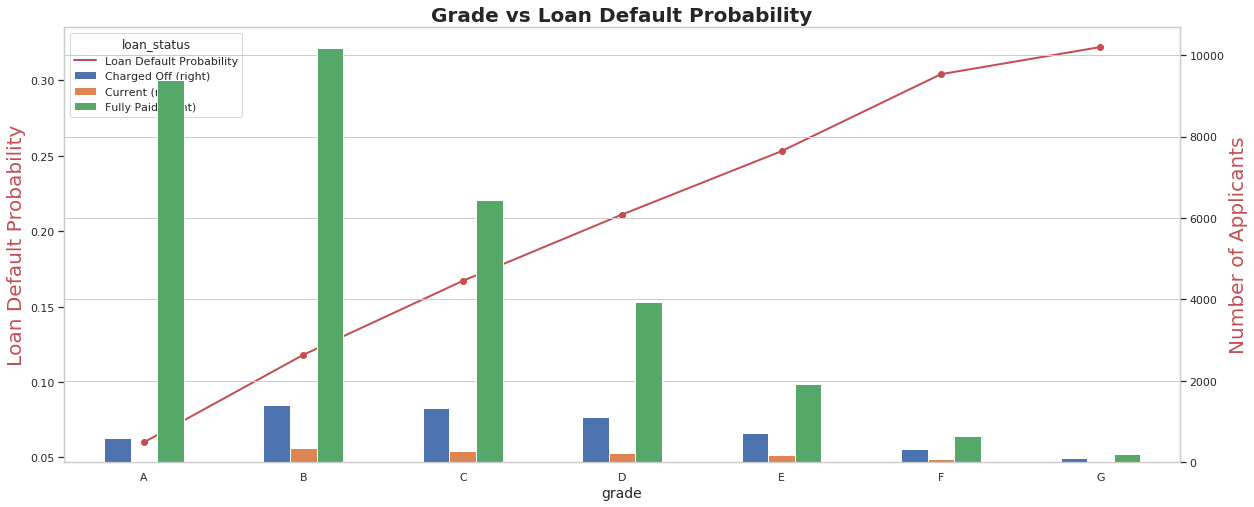

In [58]:
plot_bar_line_chart(loan_df,"grade")

loan_status  Charged Off  Current  Fully Paid   All  Loan Default Probability
sub_grade                                                                    
A1           30           0        1107        1137                 0.03     
A2           74           0        1426        1500                 0.05     
A3           103          0        1692        1795                 0.06     
A4           178          13       2679        2870                 0.06     
A5           215          27       2482        2724                 0.08     
B1           169          33       1615        1817                 0.09     
B2           225          56       1757        2038                 0.11     
B3           335          92       2463        2890                 0.12     
B4           327          75       2094        2496                 0.13     
B5           356          89       2247        2692                 0.13     
C1           332          81       1702        2115                 0.16     
C2           320          78       1596        1994                 0.16     
C3           269          41       1209        1519                 0.18     
C4           211          30       986         1227                 0.17     
C5           208          32       936         1176                 0.18     
D1           167          0        757         924                  0.18     
D2           270          62       1008        1340                 0.20     
D3           254          57       850         1161                 0.22     
D4           213          63       694         970                  0.22     
D5           207          38       620         865                  0.24     
E1           197          41       519         757                  0.26     
E2           162          42       443         647                  0.25     
E3           116          37       392         545                  0.21     
E4           126          29       292         447                  0.28     
E5           107          29       269         405                  0.26     
F1           90           24       212         326                  0.28     
F2           69           16       163         248                  0.28     
F3           50           11       121         182                  0.28     
F4           53           17       96          166                  0.32     
F5           53           5        56          114                  0.47     
G1           31           10       61          102                  0.30     
G2           27           1        48          76                   0.35     
G3           19           3        25          47                   0.40     
G4           12           2        39          53                   0.23     
G5           10           1        18          29                   0.34

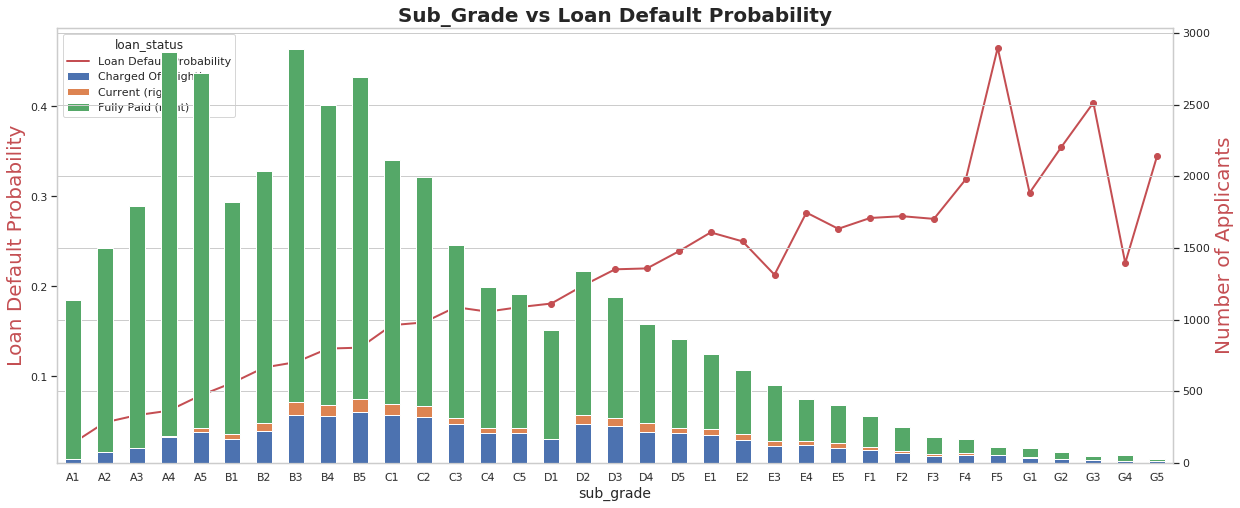

In [59]:
plot_bar_line_chart(loan_df,"sub_grade",True)

<font color='blue'/>**Analysis** -  Grade A to G, probability that person will be Defaulter, is increasing

### Plotting purpose probablility with defaulting behaviour  

loan_status         Charged Off  Current  Fully Paid    All  \
purpose                                                       
car                 159          50       1336        1545    
credit_card         539          103      4457        5099    
debt_consolidation  2753         585      15181       18519   
educational         56           0        265         321     
home_improvement    340          99       2479        2918    
house               59           14       301         374     
major_purchase      220          37       1912        2169    
medical             106          12       568         686     
moving              90           7        480         577     
other               628          127      3206        3961    
renewable_energy    19           1        81          101     
small_business      469          74       1262        1805    
vacation            53           6        322         381     
wedding             94           20       824         938     

loan_status         Loan Default Probability  
purpose                                       
car                                0.10       
credit_card                        0.11       
debt_consolidation                 0.15       
educational                        0.17       
home_improvement                   0.12       
house                              0.16       
major_purchase                     0.10       
medical                            0.15       
moving                             0.16       
other                              0.16       
renewable_energy                   0.19       
small_business                     0.26       
vacation                           0.14       
wedding                            0.10

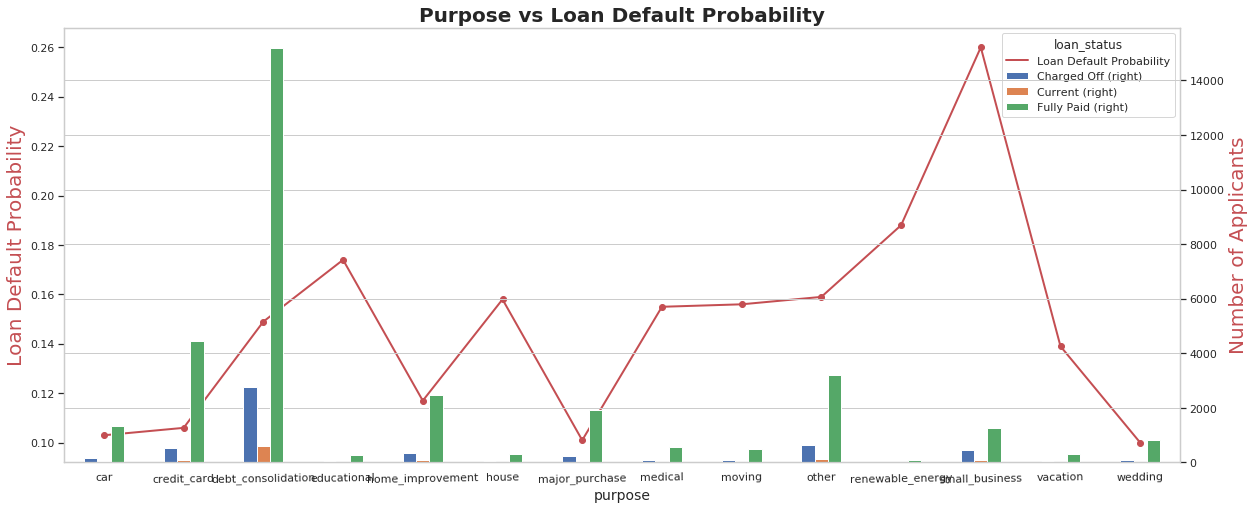

In [60]:
plot_bar_line_chart(loan_df,"purpose")

<font color='blue'/>**Analysis** - Applicants who has taken the Loan for **small business** has the highest probabilty of Likely to be as a Defaulter of 26%. So bank should take extra caution while approving the loan for purpose of 'small business'.

### Plotting Location / State probablility with defaulting behaviour  

loan_status  Charged Off  Current  Fully Paid   All  Loan Default Probability
addr_state                                                                   
AK           14           2        63          79                   0.18     
AL           54           17       378         449                  0.12     
AR           26           10       208         244                  0.11     
AZ           120          30       718         868                  0.14     
CA           1117         150      5778        7045                 0.16     
CO           96           26       659         781                  0.12     
CT           94           25       623         742                  0.13     
DC           15           3        192         210                  0.07     
DE           12           1        101         114                  0.10     
FL           498          85       2260        2843                 0.17     
GA           214          38       1131        1383                 0.15     
HI           28           8        138         174                  0.16     
IL           197          47       1266        1510                 0.13     
KS           31           16       222         269                  0.12     
KY           45           14       266         325                  0.14     
LA           53           9        367         429                  0.12     
MA           156          43       1126        1325                 0.12     
MD           161          26       851         1038                 0.15     
MI           102          16       595         713                  0.14     
MN           81           10       523         614                  0.13     
MO           113          16       552         681                  0.17     
MS           2            0        16          18                   0.11     
MT           11           2        71          84                   0.13     
NC           114          38       631         783                  0.15     
NH           25           5        141         171                  0.15     
NJ           277          59       1495        1831                 0.15     
NM           30           5        151         186                  0.16     
NV           107          17       368         492                  0.22     
NY           491          113      3175        3779                 0.13     
OH           153          45       1020        1218                 0.13     
OK           40           12       247         299                  0.13     
OR           71           16       363         450                  0.16     
PA           178          49       1285        1512                 0.12     
RI           25           4        166         195                  0.13     
SC           66           13       390         469                  0.14     
SD           12           2        50          64                   0.19     
TN           2            0        15          17                   0.12     
TX           313          68       2323        2704                 0.12     
UT           40           6        211         257                  0.16     
VA           176          38       1179        1393                 0.13     
VT           6            1        45          52                   0.12     
WA           127          22       689         838                  0.15     
WI           63           20       375         458                  0.14     
WV           21           5        151         177                  0.12     
WY           4            3        76          83                   0.05

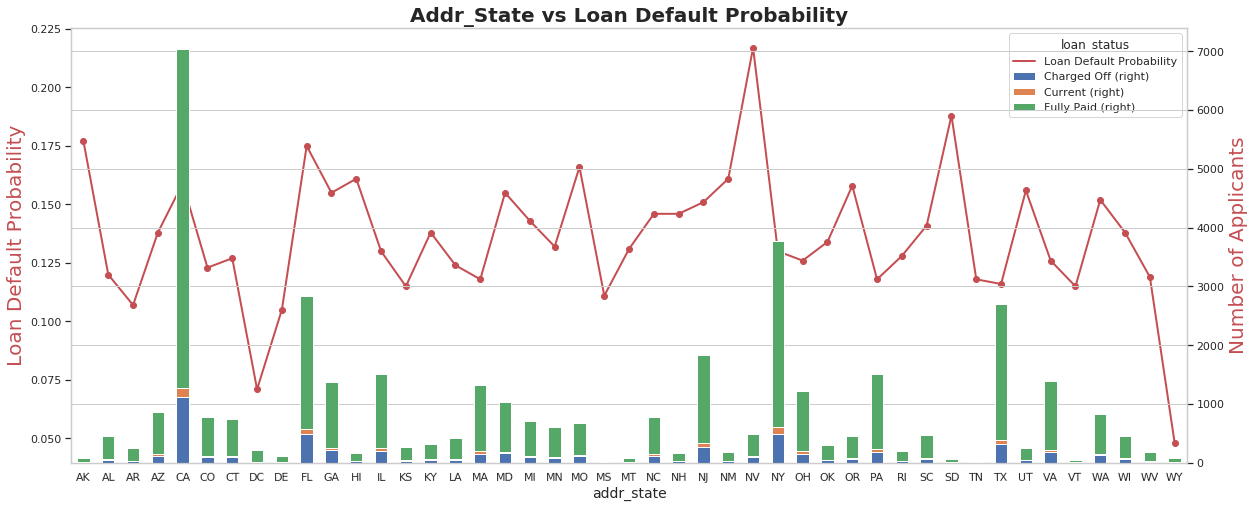

In [61]:
# Removing  Address state those having vary small value, which will impact the Probability Analysis

filter_states = loan_df.addr_state.value_counts()
filter_states = filter_states[(filter_states < 10)]

loan_filter_states = loan_df.drop(labels = loan_df[loan_df.addr_state.isin(filter_states.index)].index)

plot_bar_line_chart(loan_filter_states,"addr_state",True)

<font color='blue'/>**Analysis** -  There are multiple States/Provinces with high probability of Likely to be a Defaulter ,highest being 'NV' at 22%

### For the Probability Graph with Continous Variable not gives us significant view in the plot, hence we require a Range for Loan Ammount, Interest Rate and Annual Income

In [62]:
# Create Bins for range of Loan Amount

bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
loan_df['loan_amnt_range'] = pd.cut(loan_df['loan_amnt'], bins, labels=slot)

# Create Bins for range of Annual Income

bins = [0, 25000, 50000, 75000, 100000,1000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
loan_df['annual_inc_range'] = pd.cut(loan_df['annual_inc'], bins, labels=slot)

# Create Bins for range of Interest rates

bins = [0, 7.5, 10, 12.5, 15,20]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
loan_df['int_rate_range'] = pd.cut(loan_df['int_rate'], bins, labels=slot)

loan_df.head()

loan_amnt          funded_amnt      funded_amnt_inv        term  \
0             5,000.00             5,000.00             4,975.00   36 months   
1             2,500.00             2,500.00             2,500.00   60 months   
2             2,400.00             2,400.00             2,400.00   36 months   
3            10,000.00            10,000.00            10,000.00   36 months   
4             3,000.00             3,000.00             3,000.00   60 months   

              int_rate          installment grade sub_grade emp_length  \
0                10.65               162.87  B     B2        10+ years   
1                15.27                59.83  C     C4        < 1 year    
2                15.96                84.33  C     C5        10+ years   
3                13.49               339.31  C     C1        10+ years   
4                12.69                67.79  B     B5        1 year      

  home_ownership           annual_inc verification_status issue_d  \
0  RENT                     24,000.00  Verified            Dec-11   
1  RENT                     30,000.00  Verified            Dec-11   
2  RENT                     12,252.00  Not Verified        Dec-11   
3  RENT                     49,200.00  Verified            Dec-11   
4  RENT                     80,000.00  Verified            Dec-11   

   loan_status         purpose                 title addr_state  \
0  Fully Paid   credit_card     Computer              AZ          
1  Charged Off  car             bike                  GA          
2  Fully Paid   small_business  real estate business  IL          
3  Fully Paid   other           personel              CA          
4  Current      other           Personal              OR          

                   dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0                27.65  0            Jan-85           1                
1                 1.00  0            Apr-99           5                
2                 8.72  0            Nov-01           2                
3                20.00  0            Feb-96           1                
4                17.94  0            Jan-96           0                

   open_acc  pub_rec  revol_bal revol_util  total_acc            out_prncp  \
0  3         0        13648      83.70%     9                         0.00   
1  3         0        1687       9.40%      4                         0.00   
2  2         0        2956       98.50%     10                        0.00   
3  10        0        5598       21%        37                        0.00   
4  15        0        27783      53.90%     38                      524.06   

         out_prncp_inv          total_pymnt      total_pymnt_inv  \
0                 0.00             5,863.16             5,833.84   
1                 0.00             1,008.71             1,008.71   
2                 0.00             3,005.67             3,005.67   
3                 0.00            12,231.89            12,231.89   
4               524.06             3,513.33             3,513.33   

       total_rec_prncp        total_rec_int   total_rec_late_fee  \
0             5,000.00               863.16                 0.00   
1               456.46               435.17                 0.00   
2             2,400.00               605.67                 0.00   
3            10,000.00             2,214.92                16.97   
4             2,475.94             1,037.39                 0.00   

            recoveries  collection_recovery_fee last_pymnt_d  \
0                 0.00                 0.00      Jan-15        
1               117.08                 1.11      Apr-13        
2                 0.00                 0.00      Jun-14        
3                 0.00                 0.00      Jan-15        
4                 0.00                 0.00      May-16        

       last_pymnt_amnt last_credit_pull_d  pub_rec_bankruptcies  \
0               171.62  May-16                            0.00    
1               119.66  Sep-13

### Annual Income Range vs Probability Likely to be Defaulter

loan_status       Charged Off  Current  Fully Paid    All  \
annual_inc_range                                            
0-25000           487          26       2056        2569    
25000-50000       2119         329      10687       13135   
50000-75000       1679         359      9959        11997   
75000-100000      733          220      5287        6240    
100000 and above  567          201      4685        5453    

loan_status       Loan Default Probability  
annual_inc_range                            
0-25000                          0.19       
25000-50000                      0.16       
50000-75000                      0.14       
75000-100000                     0.12       
100000 and above                 0.10

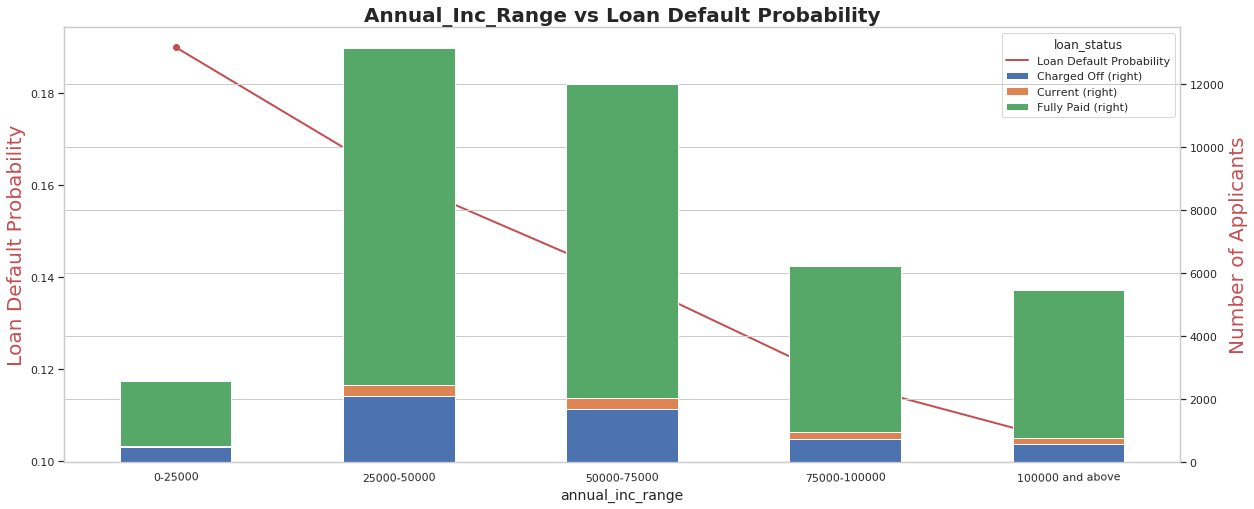

In [63]:
plot_bar_line_chart(loan_df,"annual_inc_range",stacked=True)

<font color='blue'/>**Analysis** - As the annual income is decreasing the probability that person will default is increasing with highest of **19% at (0 to 25000)** salary bracket

### Interest Rate Range vs Probability Likely to be Defaulter

loan_status     Charged Off  Current  Fully Paid   All  \
int_rate_range                                           
0-7.5           256          7        5098        5361   
7.5-10          570          70       6318        6958   
10-12.5         1219         270      8083        9572   
12.5-15         1469         257      7343        9069   
15 and above    1779         429      5372        7580   

loan_status     Loan Default Probability  
int_rate_range                            
0-7.5                          0.05       
7.5-10                         0.08       
10-12.5                        0.13       
12.5-15                        0.16       
15 and above                   0.23

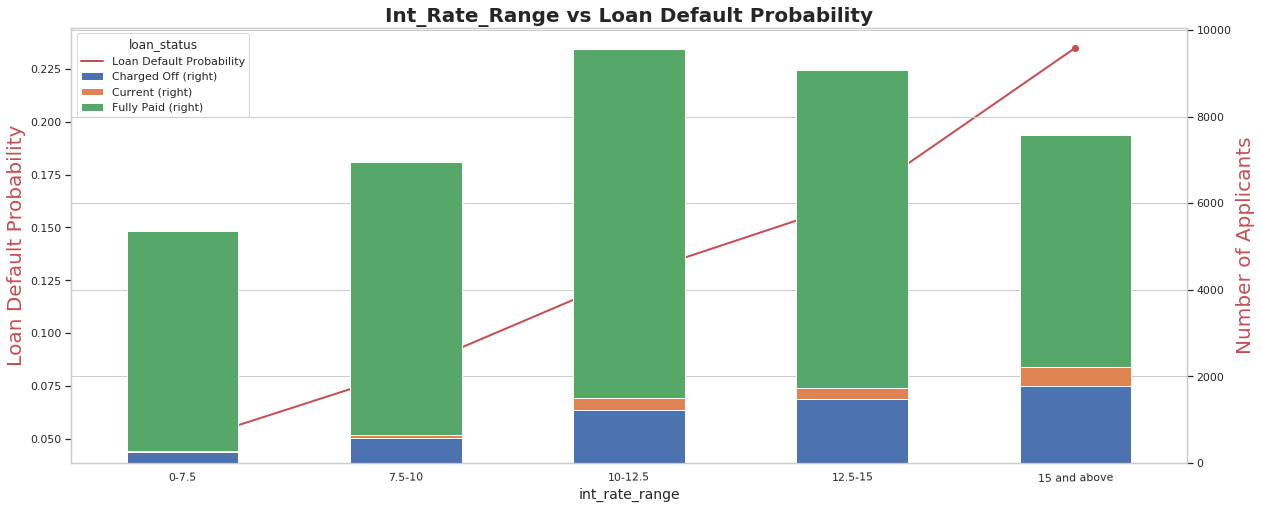

In [64]:
plot_bar_line_chart(loan_df,"int_rate_range",stacked=True)

<font color='blue'/>**Analysis** -  As the interest rate is increasing the probability that person will default is increasing with highest at 15% & above bracket

### Loan Amount Range vs Probability Likely to be Defaulter

loan_status      Charged Off  Current  Fully Paid    All  \
loan_amnt_range                                            
0-5000           1309         96       8118        9523    
5000-10000       1636         158      11088       12882   
10000-15000      1046         303      6588        7937    
15000-20000      740          240      3559        4539    
20000-25000      535          161      2253        2949    
25000 and above  319          177      1068        1564    

loan_status      Loan Default Probability  
loan_amnt_range                            
0-5000                          0.14       
5000-10000                      0.13       
10000-15000                     0.13       
15000-20000                     0.16       
20000-25000                     0.18       
25000 and above                 0.20

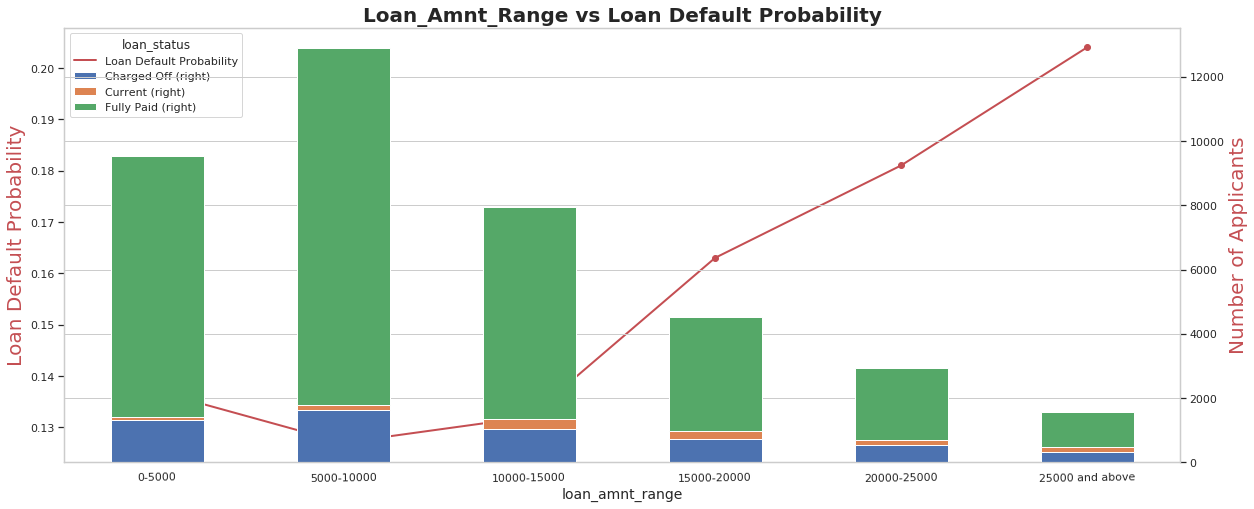

In [65]:
plot_bar_line_chart(loan_df,"loan_amnt_range",stacked=True)

<font color='blue'/>**Analysis** -  As the Loan Amount is increasing the probability that person will default is increasing with highest at 25000 & above bracket

----